# Komparasi Klasifikasi Jenis Tanaman Rimpang Menggunakan SVM, KNN dan Decision Tree

Ide kali ini adalah untuk melakukan klasifikasi algoritma yang berbeda yaitu SVM, K-NN dan Decision Tree. Disini juga akan menerapkan PRINCIPAL COMPONENT ANALYSIS (PCA) untuk mengurangi dimensi dataset, melihat varians setiap kelas dan kemudian akan mencoba menerapkan algoritma klasifikasi yang hanya memiliki dua dimensi. Pada akhirnya akan dilakukan ujicoba perbandingan antara semua metode untuk menemukan algoritma mana yang berkinerja lebih baik pada dataset ini.

In [ ]:
# Import File citra dari drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library Yang Dibutuhkan

In [ ]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

print(os.listdir("/content/drive/MyDrive/Rimpang_Klasifikasi/dataset"))
dim = 100

['train', 'test']


# Persiapan Dataset

In [ ]:
def getYourRimpang(rimpang, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['train', 'test']
    if not k_fold:
        path = "/content/drive/MyDrive/Rimpang_Klasifikasi/dataset/" + data_type + "/"
        for i,f in enumerate(rimpang):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR) # memuat gambar berwarna
                image = cv2.resize(image, (dim, dim)) # merubah ukuran menjadi dim (100x100)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # konversi warna ke bgr
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , rimpang[i].upper())
        images = np.array(images) # mendefinisikan citra ke array
        labels = np.array(labels) # mendefinisikan label ke array
        return images, labels
    else:
        for v in val:
            path = "/content/drive/MyDrive/Rimpang_Klasifikasi/dataset/" + v + "/"
            for i,f in enumerate(rimpang):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR) # memuat gambar berwarna
                    image = cv2.resize(image, (dim, dim)) # merubah ukuran menjadi dim (100x100)
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # konversi warna ke bgr
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images) # mendefinisikan citra ke array
        labels = np.array(labels) # mendefinisikan label ke array
        return images, labels
    
def getAllRimpang():
    rimpang = []
    for rimpangs_path in glob.glob("/content/drive/MyDrive/Rimpang_Klasifikasi/dataset/train/*"):
        rimpangs = rimpangs_path.split("/")[-1]
        rimpangs.append(rimpangs)
    return rimpang

# Membuat Kelas

In [ ]:
# Memilih Rimpang
rimpang = ['jahe', 'kencur', 'kunci', 'kunyit', 'laos'] 

# Mendapatkan Citra dan Label 
X_t, y_train =  getYourRimpang(rimpang, 'train', print_n=True, k_fold=False)
X_test, y_test = getYourRimpang(rimpang, 'test', print_n=True, k_fold=False)

# Mendapatkan data untuk k-fold
X,y = getYourRimpang(rimpang, '', print_n=True, k_fold=True)

# Scale Data Citra
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

There are  349   TRAIN  images of  JAHE
There are  360   TRAIN  images of  KENCUR
There are  351   TRAIN  images of  KUNCI
There are  354   TRAIN  images of  KUNYIT
There are  355   TRAIN  images of  LAOS
There are  38   TEST  images of  JAHE
There are  40   TEST  images of  KENCUR
There are  35   TEST  images of  KUNCI
There are  40   TEST  images of  KUNYIT
There are  38   TEST  images of  LAOS


Setiap gambar dikonversi dalam array numpy 100x100 untuk setiap dimensi RGB (x3). Kemudian telah diratakan dalam satu vektor tunggal (Image Features Vector) dan kemudian diskalakan dengan mengurangkan mean dari dataset untuk melakukan algoritma klasifikasi.

Pada gambar di bawah matriks terakhir adalah X_train kami, dengan bentuk 30000x980

# Visualisasi Data

Mari kita lihat sekarang bagaimana salah satu sampel kami muncul 

In [ ]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1  

jahe


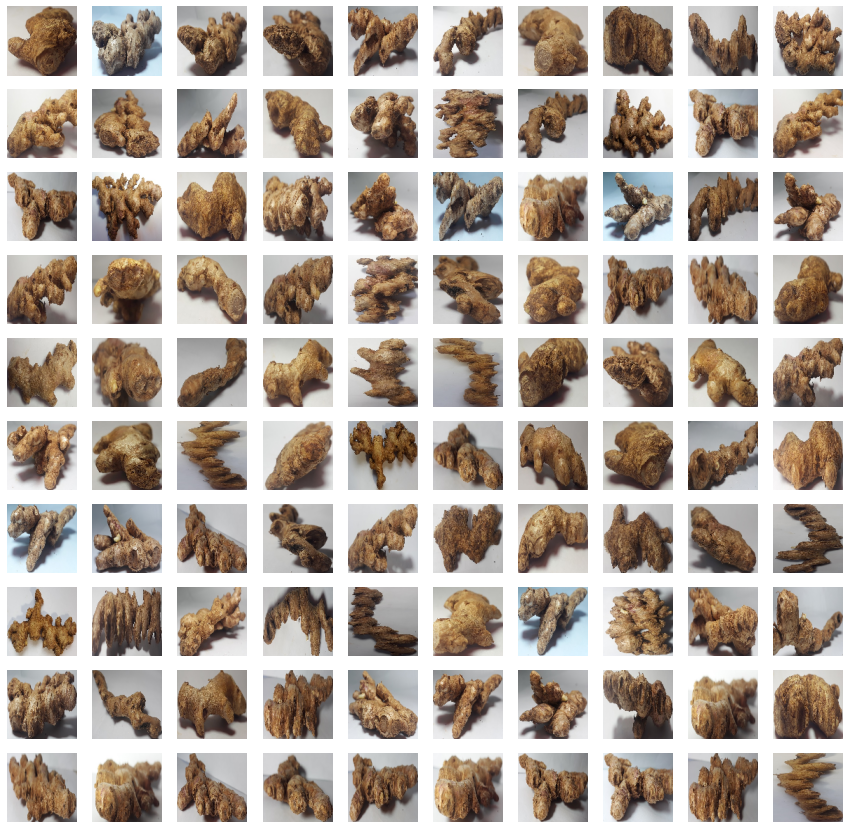

In [ ]:
# menampilkan sample data train jahe
print(rimpang[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_jahe.png')

kencur


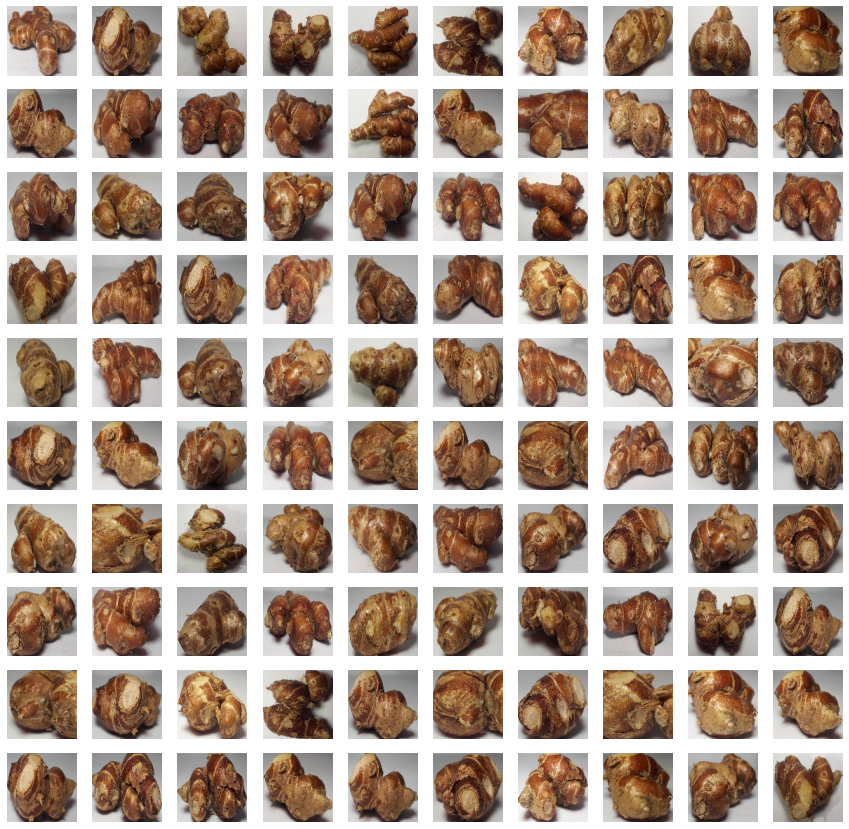

In [ ]:
# menampilkan sample data train jahe
print(rimpang[y_train[361]])
plot_image_grid(X_t[361:461], 10, 10)
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_kencur.png')

In [ ]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = rimpang[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_PCA2D.png')
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = rimpang[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_PCA3D.png')
    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Fungsi ini mencetak dan memplot matriks konfusi.
     Normalisasi dapat diterapkan dengan mengatur `normalisasi=True`. 
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Menghitung confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Hanya gunakan label yang muncul di data 
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Menampilkan keseluruhan data
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... dan beri label dengan entri daftar masing-masing 
           xticklabels=rimpang, yticklabels=rimpang,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Putar label centang dan atur perataannya.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Ulangi dimensi data dan buat anotasi teks. 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

# DATA DIMENSI RENDAH 

Untuk menemukan bagaimana data kami muncul di dimensi yang lebih rendah, kami perlu mengurangi dimensi kumpulan data dalam 2 atau 3 dimensi sehingga kami dapat memplot dan memvisualisasikannya. Untuk melakukan ini saya telah memutuskan untuk menggunakan Analisis Komponen Utama, dijelaskan dalam bab berikutnya, tetapi solusi yang lebih baik dapat menggunakan t-SNE (T-distributed Stochastic Neighbor Embedding) atau MDS (Multi Dimensional Scaling), teknik reduksi dimensi nonlinier dengan baik -cocok untuk menyematkan data dimensi tinggi untuk visualisasi dalam ruang dimensi rendah dua atau tiga dimensi.
Tidak ada asumsi tentang linearitas dataset yang dapat dibuat dengan mempertimbangkan grafik tersebut. 

**DATA Dalam 2D**

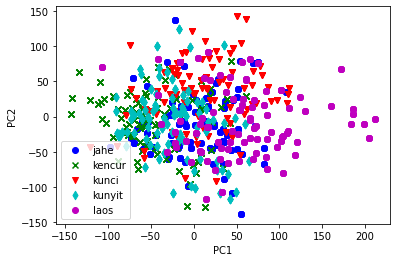

In [ ]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2)

**DATA Dalam 3D**

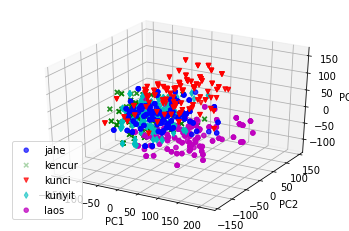

In [ ]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3)

# PRINCIPAL COMPONENT ANALYSIS 

Principal Component Analysis adalah teknik yang digunakan untuk mengurangi dimensi kumpulan data sambil mempertahankan informasi sebanyak mungkin. Data diproyeksikan ulang dalam ruang dimensi yang lebih rendah, khususnya kita perlu menemukan proyeksi yang meminimalkan kesalahan kuadrat dalam merekonstruksi data asli.

Ada 3 teknik berbeda untuk menerapkan PCA:
1.   Sequential
2.   Sample Covariance Matrix
3.   Singular Value Decomposition (SVD)

In [ ]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_Sample_PCA.png')
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id].reshape(1, -1))
    return newImage

def showVariance(X_train):
    # Menghitung secara manual komponen utama 
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] # Urutkan indeks vektor terurut (urutan menaik) 
 
    eigvect=eigvect[:,index]
    eigval=eigval[index]

    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(10):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots(figsize=(8,8))

    ind = np.arange(10)    
    width = 0.35         # lebar batang 
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')

    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()
    plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_Variance.png')
    plt.show()

# Contoh PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


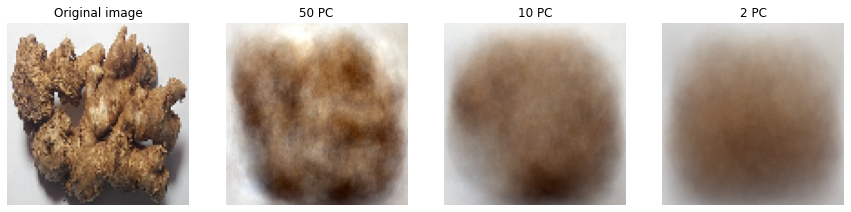

In [ ]:
image_id = 9
image = X_t[image_id]

# Menghitung PCA
X_2 = computePCA(2, X_train,image_id)
X_10 = computePCA(10, X_train,image_id)
X_50 = computePCA(50, X_train,image_id)

# Bentuk ulang secara berurutan untuk membuat plot gambar
X2 = np.reshape(X_2, (dim,dim,3)).astype(int)
X10 = np.reshape(X_10, (dim,dim,3)).astype(int)
X50 = np.reshape(X_50, (dim,dim,3)).astype(int)

# Plot
showPCA(image, X2, X10, X50)

**Komentar**

Dari gambar-gambar itu dimungkinkan untuk memahami bagaimana mempertimbangkan hanya sampel dan memperoleh komponen utamanya dari seluruh dataset, memungkinkan kita untuk mengklasifikasikan tanaman rimpang dengan mudah hanya dengan mempertimbangkan dimensi angka rendah daripada semua. Ini berarti banyak data yang lebih sedikit.
Jelas untuk algoritma klasifikasi akurasi klasifikasi akan lebih rendah tetapi waktu pelatihan akan lebih cepat, jika kelas dipisahkan secara linier akurasinya bisa memuaskan. 

# VARIANSI DIJELASKAN MENGGUNAKAN PC

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


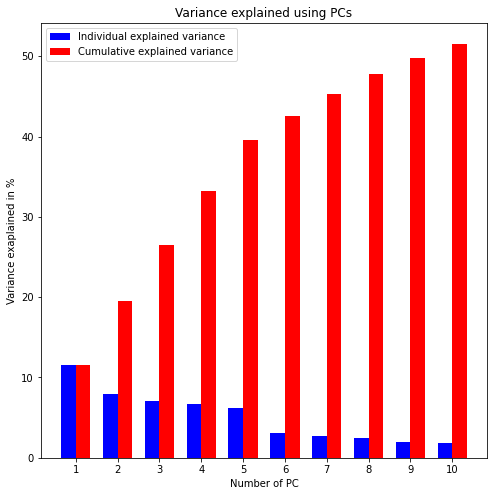

In [ ]:
showVariance(X_train)

# LINEAR SVM

Accuracy with SVM: 91.10%


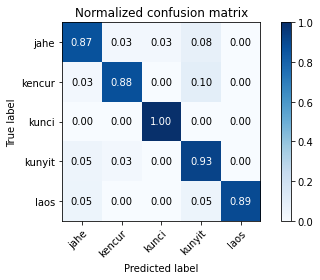

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


In [ ]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y_train) 
y_pred = svm.predict(X_test)

# Evaluasi
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred,
                               classes=y_train, 
                               normalize=True, 
                               title='Normalized confusion matrix')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_LINEAR_SVM.png')
plt.show()

# Menghitung FPR dan TPR untuk semua thresholds dari klasifikasi
probs = svm.predict_proba(X_test)
svm_auc = metrics.roc_auc_score(y_test, probs, multi_class='ovr')

prob = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=prob)
# print(svm_auc)

# SVM + K-FOLD

In [ ]:
pred_kfold = cross_val_score(svm, X, y, cv=5) 
print("Accuracy with SVM and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with SVM and K-FOLD CROSS VALIDATION: 0.99 (+/- 0.03)


# LINEAR SVM + PCA

Accuracy with SVM considering only first 2PC: 46.07%


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


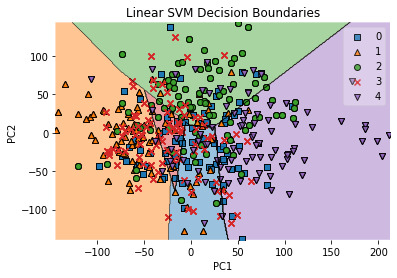

In [ ]:
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

svm.fit(X_train2D, y_train) 
test_predictions = svm.predict(X_test2D)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM considering only first 2PC: {0:.2f}%".format(precision))

# Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=svm, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Linear SVM Decision Boundaries')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_LINEAR_SVM+PCA.png')
plt.show()

# KERNEL SVM + PCA

Accuracy with Not-Linear SVM considering only first 2PC: 32.46%


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


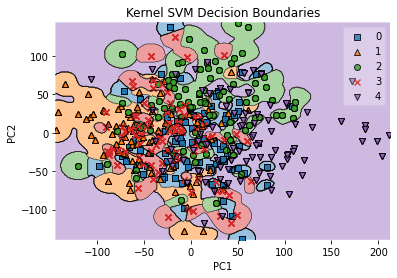

In [ ]:
svm_with_kernel = SVC(gamma=0.01, kernel='rbf', probability=True)
svm_with_kernel.fit(X_train2D, y_train) 
y_pred = svm_with_kernel.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Not-Linear SVM considering only first 2PC: {0:.2f}%".format(precision))

# Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=svm_with_kernel, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kernel SVM Decision Boundaries')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_Kernel_SVM+PCA.png')
plt.show()

# K-NEAREST NEIGHBOR

Accuracy with K-NN: 84.29%


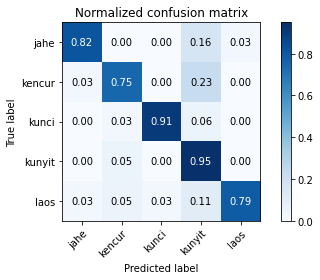

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluasi
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, 
                               normalize=True, 
                               title='Normalized confusion matrix')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_KNN.png')
plt.show()

# Menghitung FPR dan TPR untuk semua thresholds dari klasifikasi
probs = knn.predict_proba(X_test)
knn_auc = metrics.roc_auc_score(y_test, probs, multi_class='ovr')

prob = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=prob)
# print(knn_auc)

In [ ]:
# KNN + K-FOLD
pred_kfold = cross_val_score(knn, X, y, cv=5) 
print("Accuracy with K-NN and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with K-NN and K-FOLD CROSS VALIDATION: 0.99 (+/- 0.06)


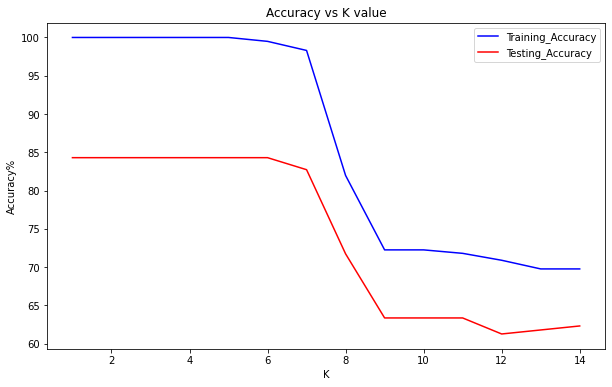

In [ ]:
# MENGUBAH NILAI N
accuracy_train = []
accuracy_test = []

for i in range(1,15):   # periksa semua kemungkinan nilai untuk 1 sampai 15
    k_nn = KNeighborsClassifier(n_neighbors=i)
    k_nn.fit(X_train,y_train)
    pred_i = k_nn.predict(X_test)
    accuracy_train.append(k_nn.score(X_train,y_train)*100)
    accuracy_test.append(k_nn.score(X_test,y_test)*100)
    
accuracy_train_array=np.asarray(accuracy_train)
accuracy_test_array=np.asarray(accuracy_test)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,15),accuracy_train_array, label='Training_Accuracy', color='blue')
plt.plot(range(1,15),accuracy_test_array, label='Testing_Accuracy', color='red')
plt.legend()
plt.title('Accuracy vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy%')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_Accuracy_vs_K_value.png')
plt.show()

Accuracy with K-NN considering only first 2PC: 28.80%


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


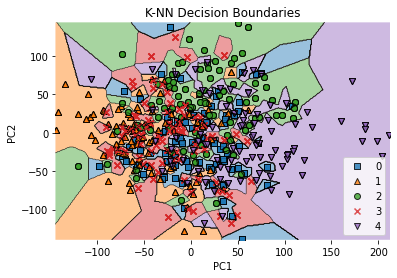

In [ ]:
# K-NN + PCA
knn.fit(X_train2D, y_train)
y_pred = knn.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN considering only first 2PC: {0:.2f}%".format(precision))

# Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=knn, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-NN Decision Boundaries')
plt.legend()
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_KNN+PCA.png')
plt.show()

# DECISION TREE

Accuracy with Decision Tree: 79.58%


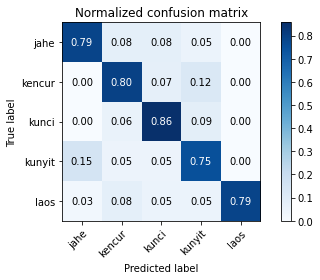

In [ ]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

# Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, 
                               normalize=True, 
                               title='Normalized confusion matrix')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_Decision_Tree.png')
plt.show()

# Menghitung FPR dan TPR untuk semua thresholds dari klasifikasi
probs = tree.predict_proba(X_test)
tree_auc = metrics.roc_auc_score(y_test, probs, multi_class='ovr')

prob = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=prob)
# print(tree_auc)

In [ ]:
# DECISION TREE + K-FOLD
pred_kfold = cross_val_score(tree, X, y, cv=5) 
print("Accuracy with DECISION TREE and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with DECISION TREE and K-FOLD CROSS VALIDATION: 0.98 (+/- 0.07)


Accuracy with Decision Tree considering only first 2PC: 30.89%


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


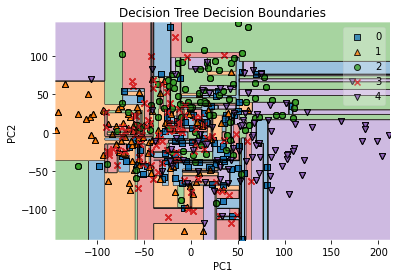

In [ ]:
# DECISION TREE + PCA
tree = tree.fit(X_train2D,y_train)
y_pred = tree.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree considering only first 2PC: {0:.2f}%".format(precision))

# Plotting decision boundaries
plot_decision_regions(X_train2D, y_train, clf=tree, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Tree Decision Boundaries')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_Decision_Tree+PCA.png')
plt.show()

# EVALUASI MODEL

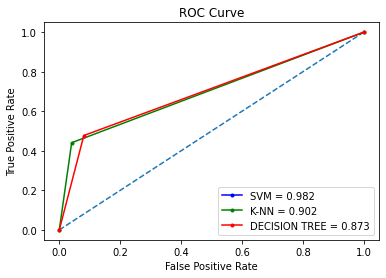

In [ ]:
# Plot ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(tree_fpr, tree_tpr, 'r', marker='.',label = 'DECISION TREE = %.3f' % tree_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('/content/drive/MyDrive/Rimpang_Klasifikasi/output1/plot_Roc_Curve.png')
plt.show()